<a href="https://colab.research.google.com/github/OZambranoE/predicciones-de-ventas/blob/main/predicciones_de_ventas_final_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importar librerias y cargar datos
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

filename = "/content/drive/MyDrive/Codificación de Dojo/SemanaM1/sales_predictions.csv"
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [2]:
df['Item_Fat_Content'].value_counts()
# Podemos ver que hay algunos valores incoherentes.

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [3]:
# Se utiliza replace para arreglar la tabla antes del procesamiento.
# Si fuera un estudiuo de salud, se codificaria de inmediato como columnas ordinales, pero no es el caso.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat')

In [4]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['reg'], 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [5]:
# Hay columnas que no nos entregan informacion relevante, por lo que se creará un nuevo data frame con las columnas de interes para la prediccion. Se pasa de 12 a 9 columnas.

df2 = df[["Item_Weight", "Item_Fat_Content", "Item_Visibility", "Item_Type", "Item_MRP", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type", "Item_Outlet_Sales"]]
df2.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


In [6]:
# Se examinan los datos y se observa que hay 2 columnas con datos faltantes (como antes)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           7060 non-null   float64
 1   Item_Fat_Content      8523 non-null   object 
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   object 
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Size           6113 non-null   object 
 6   Outlet_Location_Type  8523 non-null   object 
 7   Outlet_Type           8523 non-null   object 
 8   Item_Outlet_Sales     8523 non-null   float64
dtypes: float64(4), object(5)
memory usage: 599.4+ KB


In [7]:
# Se definen X e y
y = df2['Item_Outlet_Sales']
X = df2.drop(columns = 'Item_Outlet_Sales')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
# Instanciar selectores de columnas
cat_selector = make_column_selector(dtype_include= "object")
num_selector = make_column_selector(dtype_include= "number")

In [9]:
# Instanciar transformadores para rellenar datos faltantes y para escalar datos
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

#Escalar
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown= "ignore", sparse= False)

In [10]:
# Instanciar pipelines

# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [11]:
# Instanciar pipelines

# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [12]:
# Instanciar ColumnTransformer
# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd46721fc10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd46721ff70>)])

In [13]:
# Transformador de datos
# Ajustaremos el ColumnTransformer, el cual se llamará “preprocessor” en los datos de entrenamiento.  (Nunca en los datos de prueba)
# fit on train
preprocessor.fit(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd46721fc10>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fd46721ff70>)])

In [14]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [15]:
# Inspeccionar el resultado
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 31)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

Se comienza con un modelo de regresion lineal

In [16]:
#se comienza con la regresion lineal
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

In [17]:
# El modelo está aprendiendo la relación entre X e y.
reg.fit(X_train_processed, y_train)

LinearRegression()

In [18]:
# se cargan las metricas
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [19]:
#evaluando el modelo con R^2 (coeficiente de determinación)
train_score = reg.score(X_train_processed, y_train)
print(train_score)
test_score = reg.score(X_test_processed, y_test)
print(test_score)

0.5606153870287736
0.5656025072798097


In [20]:
# se obtienen las predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train_processed)
# se obtienen las predicciones del conjunto de prueba
test_preds = reg.predict(X_test_processed)

In [21]:
#Evaluando con Raíz del error cuadrático medio (RECM)
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
print(rmse_train)
print(rmse_test)

1140.3242079947659
1094.7569667716948


Ahora un modelo de arbol de regresion

In [22]:
# se importa e intancia el modelo (por defecto)
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(random_state = 42)

In [23]:
# se ajusta el modelo usando los datos de entrenamiento.  El modelo está aprendiendo la relación entre las características (X) y el objetivo (y).
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [24]:
# predecir los valores objetivos para el conjunto de entrenamiento y de prueba.
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [25]:
# se evalua el modelo con R^2 (coeficiente de determinación)
#se observa que el modelo esta groseramente sobreentrenado.
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

1.0
0.11426093831941997


In [26]:
# se observa la profundidad por defecto
dec_tree.get_depth()

42

In [27]:
# Lista de valores a probar para max_depth (para poder ajustar el modelo):
max_depth_range = list(range(2, 42))
# Lista para almacenar la puntuación para cada valor de max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train_processed, y_train)
    score = dec_tree.score(X_test_processed, y_test)
    r2.append(score)

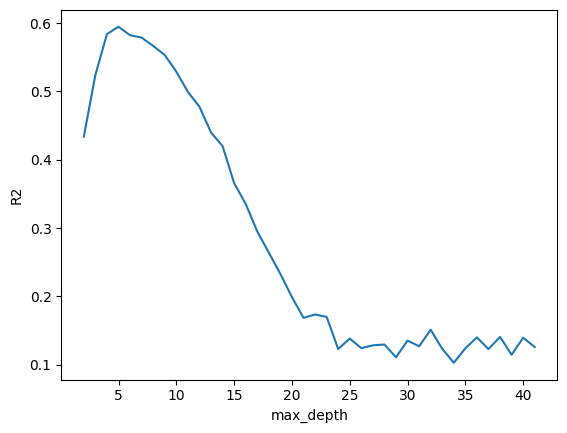

In [28]:
# Visualizar qué max_depth lleva a una puntuación R2 más alta
# se observa que el R2 mas alto se da con una profundidad de 5 
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

In [29]:
# Ejecutemos el modelo con nuestro valor optimizado para max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_processed, y_train)
# se evalua nuevamente el modelo con R^2 (coeficiente de determinación)
# se observa que el modelo mejoró bastante
train_5_score = dec_tree_5.score(X_train_processed, y_train)
test_5_score = dec_tree_5.score(X_test_processed, y_test)
print(train_5_score)
print(test_5_score)

0.6039397477322956
0.5947099753159973


In [30]:
train_preds2 = dec_tree_5.predict(X_train_processed)
test_preds2 = dec_tree_5.predict(X_test_processed)

In [31]:
# Evaluando con Raíz del error cuadrático medio (RECM)
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds2))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds2))
print(rmse_train.round(4))
print(rmse_test.round(4))

1082.6462
1057.4431


Si bien los modelos no son excesivamente sobresalientes uno con respecto al otro, si es posible señalar que el arbol de regresion presenta un mejor rendimiento al tener las dos metricas de regresion evaluadas de mejor calidad (aunque sea por poco).

#Anexo de graficas utilizadas para los análisis 

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
#el primer grafico será un histograma que relacione el monto de ventas en relacion al tipo de outlet
#para esto, lo primero es hacer un groupby entre ambas columnas
df_histo = df.groupby(['Outlet_Type'])['Item_Outlet_Sales'].sum()
df_histo

Outlet_Type
Grocery Store        3.680343e+05
Supermarket Type1    1.291734e+07
Supermarket Type2    1.851823e+06
Supermarket Type3    3.453926e+06
Name: Item_Outlet_Sales, dtype: float64

Text(0, 0.5, 'Ventas')

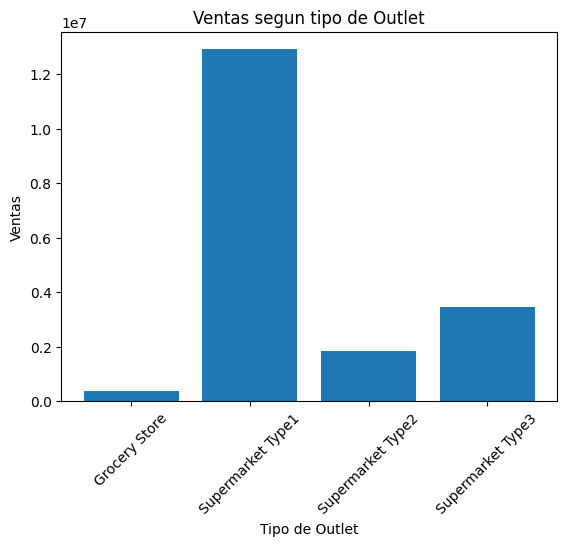

In [34]:
plt.bar(df_histo.index, df_histo.values);
plt.xticks(rotation = 45)
plt.title('Ventas segun tipo de Outlet')
plt.xlabel('Tipo de Outlet')
plt.ylabel('Ventas')
#Se observa las notables diferencias en ventas entre las tiendas, destacando sobre las demas el "Supermarket Type 1" que concentra alrededor del 50% de las ventas totales.
#En contraparte, las menores ventas las presenta "Grocery Store"

In [35]:
df_fat = df.groupby(['Item_Fat_Content'])['Item_MRP'].mean()
df_fat
#La idea es ver si existe alguna diferencia considerable en el precio medio de los productos bajos en grasa, con los de grasa regular, para ver la predispocicion en la compra de uno u otro

Item_Fat_Content
Low Fat    140.714098
Regular    141.504259
Name: Item_MRP, dtype: float64

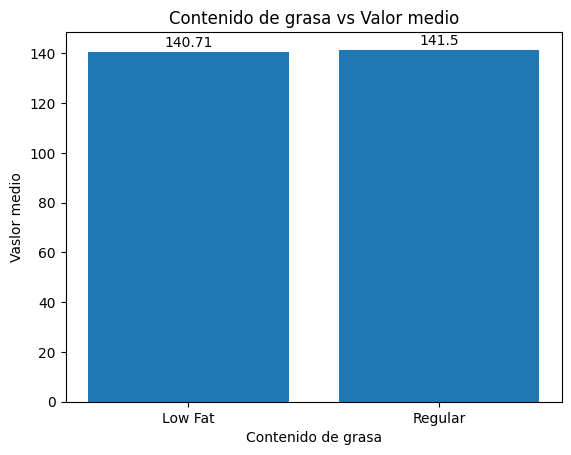

In [36]:
plt.bar(df_fat.index, df_fat.values);
plt.title('Contenido de grasa vs Valor medio')
plt.xlabel('Contenido de grasa')
plt.ylabel('Vaslor medio')
for i, v in enumerate(df_fat.values.round(2)):
  plt.text(i, v + 2, str(v), ha='center')
  #Como se observa en la gráfica, el valor medio de los productos con contenido de grasa medio y alto no serian un buen indicador de compra al ser similares.

<ipython-input-37-7269621a0f5f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

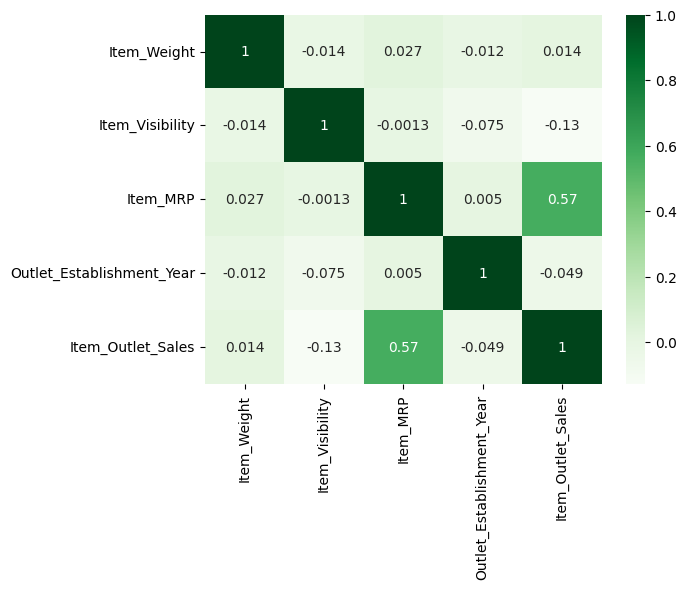

In [37]:
#Mapa de calor para observar correlaciones
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)
#No se observan mayores correlaciones positivas ni negativas entre las distintas columnas.
#La unica correlacion moderada que se observa es entre Item_MRP e Item_Outlet_Sales, ambas columnas tienen que ver con los valores en dinero de los productos,
#por lo que es esperable que si sube el valor de los items, tambien suba el valor de la suma de ventas.